In [784]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

#Set the seed for reproducibility
np.random.seed(7)
random.seed(7)

In [785]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int)
    df = df.drop(columns=["PRICES"])
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)
train.head()

,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,Hour 10,...,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24,month,day,year,day_of_week
0,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,37.99,33.11,37.99,33.00,36.48,30.65,0,0,2007,0
1,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,59.69,50.09,50.00,36.22,31.09,29.84,0,1,2007,1
2,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,60.99,55.51,51.77,34.51,39.31,38.05,0,2,2007,2
3,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,58.99,53.50,44.01,35.00,34.46,31.57,0,3,2007,3
4,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,53.00,45.91,36.74,29.61,30.61,27.51,0,4,2007,4


In [789]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, battery_capacity=50, max_power=25, efficiency=0.9):
        super(SmartGridEnv, self).__init__()

        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.efficiency = efficiency
        self.action_space = gym.spaces.Discrete(51, start=-25) 
        self.time_constraint = 6
        self.battery_time_constraint = 20
        self.initialize_params()

    def initialize_params(self):
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        self.current_battery = 20
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        self.available = True
        self.current_state = tuple([self.discretize_price(self.current_price), self.discretize_hours(self.current_hour)])
        self.state_space = [12, 3, self.action_space.n]
        self.done = False
        self.profit = 0 
        

    def car_available(self):
        if self.current_hour == 7:
            available = np.random.uniform(0, 1) < 0.5
        else:
            available = True
        return available

    def discretize_price(self, price):
        if price < 1:
            return 0
        elif price >= 100:
            return 11
        else:
            return int(price // 10) + 1

    def discretize_hours(self, hour):
        if hour in [3, 4, 5]:
            return 0
        elif hour in [10, 11, 12, 17, 18, 19]:
            return 2
        else:
            return 1
    
    def update_state(self):
        # If the car is not available, it returns at 6pm with 20kW less
        if self.available == False:
            #print('Car unavailable')
            self.current_hour = 17
            self.current_battery -= 20
        else:
            self.current_hour = int((self.current_hour + 1) % 24)
            if self.current_hour == 0:
                self.current_step += 1
                
        self.current_month = int(self.price_data.iloc[self.current_step]['month'])
        self.current_day = int(self.price_data.iloc[self.current_step]['day'])
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        # Update time step and hour
            
        self.current_state = tuple([self.discretize_price(self.current_price), self.discretize_hours(self.current_hour)])   

        # Update state
        # Check if the episode is done (after 3 years of past electricity prices)
        if self.current_step >= len(self.price_data) - 1:
            self.done = True
        
    def to_discrete(self, action):
        mask = np.zeros(self.action_space.n, dtype=np.int8)
        mask[action] = 1
        return self.action_space.sample(mask = mask)

    def reward(self, action, charge_cost):
        reward = -charge_cost + 0.05 * self.current_battery
        return reward
        
    def step(self, action):
        self.available=self.car_available()
        
        # discretize action
        if self.available == True:
            action = self.to_discrete(action) 
        else:
             action = 0
        
        # charge cost
        energy_rate = self.price_data.iloc[self.current_step, self.current_hour]
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        charge_cost = action if action < 0 else action * 2 
        charge_cost *= energy_rate / 1000
        
        # update battery
        actual_charge = np.round(self.efficiency * action).astype(int) if action>0 else np.round(action/self.efficiency).astype(int)
        self.current_battery += actual_charge
        
        # update variables
        self.profit += -charge_cost

        # reward
        reward = self.reward(action, charge_cost)
        
        self.update_state()
        return self.current_state, reward, self.done, self.available


In [709]:
class QAgent():
    def __init__(self, env, discount_rate = 0.9, learning_rate=0.01, epsilon=0.8):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Qtable = np.zeros(env.state_space)
        self.profit = []

    def mask(self):
        # 7 am constraint  
        if self.env.current_hour == self.env.time_constraint and self.env.current_battery >= self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint- self.env.current_battery)*0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity-self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        elif self.env.current_hour == self.env.time_constraint and self.env.current_battery < self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint-self.env.current_battery)/0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity-self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        else: 
            lower_bound = max(np.ceil(-(self.env.current_battery)*0.9), -self.env.max_power)
            upper_bound = min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        
        # construct boolean mask_vector
        mask = np.arange(self.env.action_space.start, self.env.action_space.start + self.env.action_space.n)
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()
        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            action = np.random.choice(np.arange(env.action_space.n)[mask])
        
        #pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action
        
        return action

    def train(self, simulations = 100, epsilon = 0.05):
        for i in range(simulations):
            self.epsilon = max(0.05, self.epsilon - 0.05)
            while not self.env.done:    
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state)
                next_state, reward, done, available= env.step(action)
                next_state_mask = self.mask()

                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta   
            
            self.profit.append(env.profit)
            self.env.initialize_params()
            
    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action

    def plot_profits(self):
        plt.plot(agent.profit)
        plt.xlabel('Epochs')  
        plt.ylabel('Profit')  
        plt.title("Cost per epoch") 

env = SmartGridEnv(train[:365])
agent = QAgent(env)
agent.train(simulations=50)
agent.plot_profits()

KeyboardInterrupt: 

In [685]:
eval_env = SmartGridEnv(val)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict(current_state)
    print(f"at time {agent.env.current_hour +  1} agent transacts {agent.env.to_discrete(action)} KWh, battery is {agent.env.current_battery}")
    next_state, reward, done, available = agent.env.step(action)

print("Profit on validation set: ", eval_env.profit)

at time 1 agent transacts -1 KWh, battery is 20
at time 2 agent transacts -1 KWh, battery is 19
at time 3 agent transacts -1 KWh, battery is 18
at time 4 agent transacts 10 KWh, battery is 17
at time 5 agent transacts 15 KWh, battery is 26
at time 6 agent transacts 1 KWh, battery is 40
at time 7 agent transacts 4 KWh, battery is 41
at time 8 agent transacts 4 KWh, battery is 45
at time 9 agent transacts -3 KWh, battery is 49
at time 10 agent transacts 4 KWh, battery is 46
at time 11 agent transacts -7 KWh, battery is 50
at time 12 agent transacts -4 KWh, battery is 42
at time 13 agent transacts -4 KWh, battery is 38
at time 14 agent transacts -1 KWh, battery is 34
at time 15 agent transacts -1 KWh, battery is 33
at time 16 agent transacts -1 KWh, battery is 32
at time 17 agent transacts -1 KWh, battery is 31
at time 18 agent transacts 5 KWh, battery is 30
at time 19 agent transacts -4 KWh, battery is 34
at time 20 agent transacts 4 KWh, battery is 30
at time 21 agent transacts 0 KWh, b

In [686]:
agent.Qtable[1, 0]

array([ 0.53675493,  0.91558516,  0.40603591,  0.47231047,  0.66833554,
        0.8824259 ,  0.65551612,  0.77272012,  0.96817645,  0.71998787,
        0.9732354 ,  1.40392544,  0.99096338,  0.93584674,  0.81283456,
        1.46540079,  1.25422813,  1.30972752,  1.29971607,  5.7218154 ,
        1.59351905,  2.27743195,  1.73359192,  1.70377198,  1.79993525,
        1.86598642, 10.75712927,  1.23605281,  1.14603268,  1.58676272,
        1.42178838,  1.40504523,  1.93104534,  1.84803368,  1.032907  ,
        1.91110374,  1.30727465,  1.21923353,  1.11457675,  1.30706821,
       10.75969388,  1.25971719,  1.49162473,  1.32280733,  1.05490691,
        1.4398173 ,  1.40979068,  1.27139414,  0.88432016,  1.07349838,
        0.9774256 ])

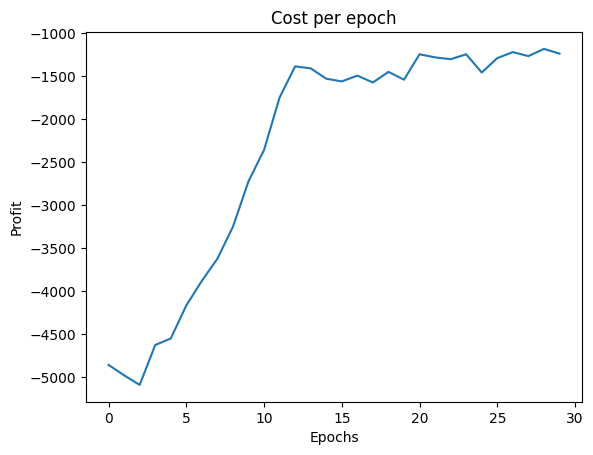

In [796]:
class SimpleQAgent(QAgent):
    def __init__(self):
        super().__init__(env)
        self.Qtable = np.zeros((12, 3, 3))
        self.actions = np.array([0, 25, 50])
        self.discount_rate = 0.9
        self.learning_rate = 0.1
        self.epsilon = 0.7

    def mask(self):
        if self.env.current_hour == self.env.time_constraint:
            return np.array([self.env.current_battery >= np.ceil(45 / 0.9),
                             self.env.current_battery >= 20, 
                             self.env.current_battery <= np.ceil(25 / 0.9)])
        else:
            return np.array([self.env.current_battery >= np.ceil(25 / 0.9),
                             True, 
                             self.env.current_battery <= np.ceil(25 / 0.9)])

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()
        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            action = np.random.choice(self.actions[mask])   
        #pick greedy action
        else:
            max_action = np.argmax(np.where(mask, self.Qtable[current_state], -100))
            action = self.actions[max_action]     
        return action

    def train(self, simulations = 100, epsilon = 0.05):
        for i in range(simulations):
            # learning_rate / epsilon decay
            self.epsilon = max(0.05, self.epsilon - 0.05)
            self.learning_rate *= 0.9
            
            while not self.env.done:
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state)
                next_state, reward, done, available= env.step(action)
                next_state_mask = self.mask()
                action = np.argwhere(self.actions == action)[0][0]

                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta 
            
            self.profit.append(env.profit)
            self.env.initialize_params()

    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(np.where(mask, self.Qtable[current_state], -100))
        action = self.actions[max_action] 
        return action

env = SmartGridEnv(train[:700])
agent = SimpleQAgent()
agent.train(simulations=30)
agent.plot_profits()

## Eval

In [797]:
eval_env = SmartGridEnv(val)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict(current_state)
    print(f"at time {agent.env.current_hour +  1} agent transacts {agent.env.to_discrete(action)} KWh, battery is {agent.env.current_battery}")
    next_state, reward, done, available = agent.env.step(action)

print("Profit on validation set: ", eval_env.profit)

at time 1 agent transacts 0 KWh, battery is 20
at time 2 agent transacts 0 KWh, battery is 20
at time 3 agent transacts 0 KWh, battery is 20
at time 4 agent transacts 0 KWh, battery is 20
at time 5 agent transacts 0 KWh, battery is 20
at time 6 agent transacts 0 KWh, battery is 20
at time 7 agent transacts 0 KWh, battery is 20
at time 8 agent transacts 0 KWh, battery is 20
at time 9 agent transacts 0 KWh, battery is 20
at time 10 agent transacts 0 KWh, battery is 20
at time 11 agent transacts 0 KWh, battery is 20
at time 12 agent transacts 25 KWh, battery is 20
at time 13 agent transacts -25 KWh, battery is 42
at time 14 agent transacts 0 KWh, battery is 14
at time 15 agent transacts 0 KWh, battery is 14
at time 16 agent transacts 0 KWh, battery is 14
at time 17 agent transacts 0 KWh, battery is 14
at time 18 agent transacts 0 KWh, battery is 14
at time 19 agent transacts 25 KWh, battery is 14
at time 20 agent transacts -25 KWh, battery is 36
at time 21 agent transacts 0 KWh, battery i

In [798]:
agent.Qtable[0, 0]

array([2.75374753, 9.02368438, 4.35367506])

In [457]:
agent.env.current_hour = 6
agent.env.current_battery = 12

mask = agent.mask()
actions = np.arange(-25, 26)
actions[mask]

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [22]:
test = np.array([1, 2, 3])
mask = np.array([True, False, True])
np.where(mask, test,  -100)

array([   1, -100,    3])